 # Lecture 13: Training deep neural networks

In [2]:
import datetime
now = datetime.datetime.now()
print("Version: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Version: 2020-03-21 19:04:51


In [3]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Vanishing and exploding gradients

Training typically relies on gradients.

*Vanishing gradients problem*: For deep networks, gradients in lower layers can become very small.  Hence, corresponding weights are not updated during training.

*Exploding gradients problem*: In some situations (typically recurrent neural networks) gradients can become very large.  Hence, weight updates are very large and the training algorithm may not converge.

In general deep neural networks can suffer from *unstable gradients*.

## Problematic activation functions

One common cause of vanishing gradients in the past was the use of the sigmoid activation function (and unit Gaussian initialisation).

In [4]:
def logit(z):
    return 1 / (1 + np.exp(-z))

[-5, 5, -0.2, 1.2]

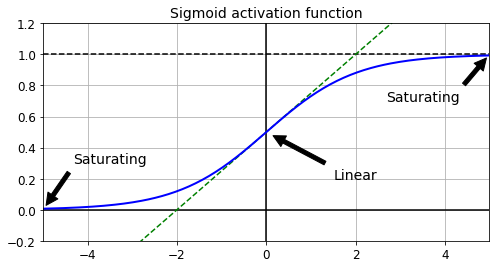

In [5]:
z = np.linspace(-5, 5, 200)
 
plt.figure(figsize=(8,4))
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

Variance of outputs grows at each layer.  Final layers essentially saturate.  Gradients on final layers then very small and when propagate gradients back with back-propagation then get vanishing gradients.

## Weight initialisation

To avoid this problem need signals and gradents to *not* decay as propagating through network.

Avoid decaying signals/gradients by promoting equal variance at outputs and inputs of layer.

Can be promoted by random initialisation of weights to follow Gaussian with standard deviation:
$$
\begin{eqnarray}
\text{Sigmoid activation:} \quad\quad & \sigma = \sqrt{\frac{2}{n_{\rm inputs}+n_{\rm outputs}}} \\
\text{Hyperbolic tangent activation:} \quad\quad & \sigma = 4\sqrt{\frac{2}{n_{\rm inputs}+n_{\rm outputs}}} \\
\text{ReLU activation:} \quad\quad & \sigma = \sqrt{2}\sqrt{\frac{2}{n_{\rm inputs}+n_{\rm outputs}}} \\
\end{eqnarray}
$$
where $n_{\rm inputs}$ and $n_{\rm outputs}$ are the number of input and output nodes, respectively, for the layer.

## Weight initialisation in Tensor Flow

In [1]:
import tensorflow as tf

/usr/local/Cellar/jupyterlab/1.2.6/libexec/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/Cellar/jupyterlab/1.2.6/libexec/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/Cellar/jupyterlab/1.2.6/libexec/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/Cellar/jupy

In [6]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [7]:
he_init = tf.contrib.layers.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1") # He initialisation

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.


## Non-saturating activation functions

ReLU activation behaves much better than the sigmoid in deep networks since it does not saturate for positive values (and it is fast to compute).

However, the ReLU does suffer from the *dying neuron* problem.

In this senario neurons effectively die and only output zero.  The neuron is unlikely to come back to life since the gradient of the ReLU activation function is zero for negative inputs.

### Leaky ReLU

The *leaky ReLU* avoids this problem and is defined by

$$
\text{LeakyReLU}_\alpha(z) = \max(\alpha z, z),
$$

where the hyperparameter $\alpha$ defines how much the leaky ReLU leaks (typically $\alpha=0.01$).

### Exercise: plot the Leaky ReLU activation function for $\alpha=0.05$.

In [8]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

[-5, 5, -0.5, 4.2]

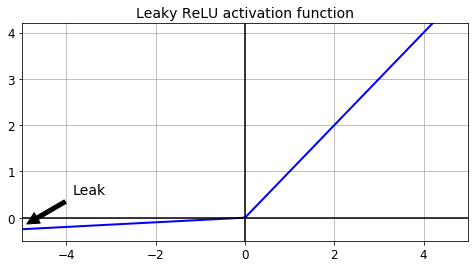

In [9]:
plt.figure(figsize=(8,4))
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

### ELU

Another alternative is the *exponental linear unit* (ELU).

In [10]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

### Exercise: plot the ELU activation function for $\alpha=1$.

[-5, 5, -2.2, 3.2]

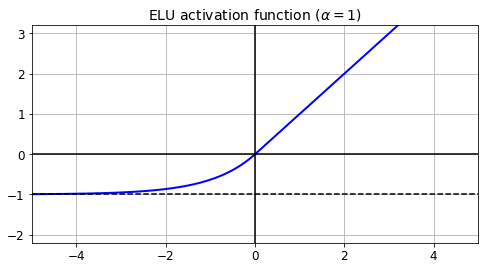

In [11]:
plt.figure(figsize=(8,4))
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

Properties:
- Non-zero gradient for $z<0$ to avoid dying neuron issue.
- Smooth so gradients well defined.
- But is slower to compute.

### ELU in Tensor Flow

In [12]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [13]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Batch normalisation

While weight normalisation can reduce gradient problems at the beginning of training, it does not guarantee that these problems won't resurface during training.

*Batch normalisation* adds normalisation during training to address these issues.

Consists of zero-centering and normalising inputs just before the activation function, followed by shifting and scaling the result.  The shift and scale are considered additional parameters that are learnt during training.

This approach allows training to select the appropriate scale and shift (mean) for each layer.

The mean and standard deviation of the unnormalised inputs are computed for each mini-batch, hence the name *batch normalisation*.

When the trained network is applied to the test set there are no batches, so instead the entire *training* set's mean and standard deviation are used.

### Batch normalisation in Tensor Flow

In [14]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, 
                                    training=training, momentum=0.9) 
    # Exponential decay is applied when computing running averages, hence the momentum parameter.
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


The Python `partial` function can be handy for defining a new function with some arguments set.

In [15]:
from functools import partial

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

## Exercise: build a deep NN with ELU activation functions and batch normalisation and apply it to MINST.

In [16]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [17]:
reset_graph()

batch_norm_momentum = 0.9
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.contrib.layers.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [18]:
n_epochs = 10
batch_size = 200

In [19]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # add moving average updates to computational graph

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy: 0.8653
1 Test accuracy: 0.8939
2 Test accuracy: 0.9086
3 Test accuracy: 0.9199
4 Test accuracy: 0.9258
5 Test accuracy: 0.9328
6 Test accuracy: 0.9379
7 Test accuracy: 0.9429
8 Test accuracy: 0.9448
9 Test accuracy: 0.9478


Performance will get better if train for longer.  In any case, ELU and batch normalisation not likely to really help with such a shallow network.

# Pretraining and transfer learning

A deep network trained for one task can often be adapted for a similar task.

Reuse lower layers of network trained for another task.

<center><img src="Lecture13_Images/transfer_learning.png" style="height: 350px;"/></center>

[Credit: Geron]

For transfer learning to be successful the data must have similar low-level features.

## Reusing a Tensor Flow model

As we saw in previous lectures we can save and load computational graphs in addition to parameters.

The computation graph is saved in `*.meta` files.

In [20]:
reset_graph()
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

In [22]:
for op in tf.get_default_graph().get_operations():
   print(op.name)

X
y
training/input
training
hidden1/kernel/Initializer/truncated_normal/shape
hidden1/kernel/Initializer/truncated_normal/mean
hidden1/kernel/Initializer/truncated_normal/stddev
hidden1/kernel/Initializer/truncated_normal/TruncatedNormal
hidden1/kernel/Initializer/truncated_normal/mul
hidden1/kernel/Initializer/truncated_normal
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
batch_normalization/gamma/Initializer/ones
batch_normalization/gamma
batch_normalization/gamma/Assign
batch_normalization/gamma/read
batch_normalization/beta/Initializer/zeros
batch_normalization/beta
batch_normalization/beta/Assign
batch_normalization/beta/read
batch_normalization/moving_mean/Initializer/zeros
batch_normalization/moving_mean
batch_normalization/moving_mean/Assign
batch_normalization/moving_mean/read
batch_normalization/moving_variance/Initializer/ones
batch_normalizatio

In [23]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
training = tf.get_default_graph().get_tensor_by_name("training:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("train/GradientDescent")

In [24]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.95
1 Test accuracy: 0.952
2 Test accuracy: 0.9547
3 Test accuracy: 0.9573
4 Test accuracy: 0.9569
5 Test accuracy: 0.9588
6 Test accuracy: 0.9601
7 Test accuracy: 0.9613
8 Test accuracy: 0.9626
9 Test accuracy: 0.963


Can then also revise the computational graph...

Typically will want to replace the upper layers of the network.

## Freezing lower layers

The lower layers of the first network have already learnt low-level features for the first task, so they can be reused as they are. 

That is, freezing their weights so that they are not altered during subsequent training of the new network.

Can be acheived by providing restricted list of training variables to optimizer:

In [26]:
# train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
#                                scope="hidden2|outputs")
# training_op = optimizer.minimize(loss, var_list=train_vars)

## Caching the frozen layers

Since the weights of the frozen layers don't change, their output for a given training instance also does not change.

Caching these outputs can provide a considerable computational saving since the entire data-set needs to be processed multiple times.

But can result in very large additional storage requirements.

## Model zoos

Many trained Tensor Flow models are available at 
[https://github.com/tensorflow/models](https://github.com/tensorflow/models).

# Improved optimizers

Although standard (stochastic) gradient descent is very effective it can still be slow for deep networks.

There are a number of more advanced optimizers that provide improvements, e.g.:
- Momentum optimization
- Nesterov accelerated gradient
- AdaGrad
- RMSProp
- Adam optimization
- ...

Recall gradient descent, with cost function $J(\theta)$ and gradients $\nabla_\theta J(\theta)$, proceeds simply by updating the weights $\theta$ by taking a step $\eta$ (learning rate) in the direction of the gradient:

$$\theta \leftarrow \theta - \eta \nabla_\theta J(\theta)$$

## Momentum optimization

Momentum optimization uses the gradients to modify a momentum vector and uses the momentum to update the weights:

1. $m \leftarrow \beta m + \eta \nabla_\theta J(\theta)$
2. $\theta \leftarrow \theta - m$

Gradient is used as an acceleration rather than speed.  Can help to traverse plateaus and to avoid local minima.

The additional hyperparameter $\beta$ is introduced as a friction term to avoid the momentum growing too large (typically $\beta \sim 0.9$).

## Nesterov accelerated gradient

Nesterov accelerated gradient is a variant of momentum optimization where the gradient is computed further ahead in the direction of the momentum:

1. $m \leftarrow \beta m + \eta \nabla_\theta J(\theta + \beta m)$
2. $\theta \leftarrow \theta - m$

In general the momentum will be pointing toward the optimum and so Nesterov modification typically provides an improvement over standard momentum optimization.

## AdaGrad

AdaGrad scales down the gradient vector along the steepest direction by incorporating a gradient squared term:

1. $s \leftarrow s + \nabla_\theta J(\theta) \otimes \nabla_\theta J(\theta)$
2. $\theta \leftarrow \theta - \eta \nabla_\theta J(\theta) \oslash \sqrt{s+\epsilon}$

Note that $\otimes$ and $\oslash$ are elementwise multiplication and division, respectively.

The parameter $\epsilon$ is introduced for numerical stability (typically $\epsilon\sim 10^{-10}$).



Basically, AdaGrad correspondings to an *adaptive learning rate* where the learning rate is decayed faster for steep directions.

Consequently, it requires much less tuning of the learning rate $\eta$.

<center><img src="Lecture13_Images/ada_grad.png" style="height: 500px;"/></center>

[Credit: Geron]

## RMSProp

RMSProp extends AdaGrad by introducing an exponential decay in the accumulated squared gradient:

1. $s \leftarrow \beta s + (1-\beta) \nabla_\theta J(\theta) \otimes \nabla_\theta J(\theta)$
2. $\theta \leftarrow \theta - \eta \nabla_\theta J(\theta) \oslash \sqrt{s+\epsilon}$

(Typically $\beta\sim 0.9$.)

Avoids the problem where AdaGrad slows down too fast and so doesn't converge to the global optimum.

## Adam optimization

Adam optimization combines momentum and RMSProp:

1. $m \leftarrow \beta_1 m + (1-\beta_1) \nabla_\theta J(\theta)$
2. $s \leftarrow \beta_2 s + (1-\beta_2) \nabla_\theta J(\theta)\otimes\nabla_\theta J(\theta)$
3. $m \leftarrow \frac{m}{1-\beta_1^{t}}$, where $t$ is the iteration number 
4. $s \leftarrow \frac{s}{1-\beta_2^{t}}$, where $t$ is the iteration number
5. $\theta \leftarrow \theta - \eta m \oslash \sqrt{s+\epsilon}$

Steps 3 and 4 are introduced to boost $m$ and $s$ at the beginnning of training (since they are initialed to 0 they can otherwise be low at the beginning).

(Typically $\beta_1 \sim 0.9$, $\beta_2 \sim 0.999$.)

# Regularization

Deep networks have many parameters (sometimes millions) and so are prone to overfitting.

Regularization therefore becomes increasingly important.

## Early stopping

A simple regularization strategy is to end training early, e.g. when performance on validation set starts to degrade.

Although early stopping works well, other regularisation techniques can lead to better performance.

## $\ell_2$ and $\ell_1$ regularization

*Tikhonov* regularization adopts $\ell_2$ regularising term (also called *Ridge regression*):


$$ R(\theta) = \frac{1}{2} \sum_{j=1}^n \theta_j^2 = \frac{1}{2}  \theta^{\rm T}\theta.$$


*Lasso* regularization adopts $\ell_1$ regularising term:

$$ R(\theta) =\sum_{j=1}^n \left\vert \theta_j \right\vert .$$

*Elastic net* regularization provides a mix of Tikhonov and Lasso regularization, controlled by mix ratio $r$:

$$ R(\theta) =  r\sum_{j=1}^n \left\vert \theta_j \right\vert + \frac{1-r}{2} \sum_{j=1}^n \theta_j^2.$$

- For $r=0$, corresponds to Tikhonov regularization.
- For $r=1$, corresponds to Lasso regularization.

## Dropout

Dropout is a very popular and effective regularlisation technique developed by [Geoff Hinton in 2012](http://www.jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf).

Dropout involves simply dropping each neuron for a given training set with probability $p$.

<center><img src="Lecture13_Images/dropout.png" style="height: 350px;"/></center>

[Credit: Geron]

Dropout encourages each neuron to be as effective as possible individually and not to rely heavily on a few nearby neurons but to consider all input neurons carefully.

The probability $p$ is called the *dropout rate* (typically $p \sim 0.5$).

After training the neurons don't get dropped.

The number of inputs of active neurons is lower when dropout is applied during training, than when the network is applied during testing.  

For example, if $p=0.5$, on average there are half as many input neurons during training than when testing.  During testing each neuron will get an input signal (approximately) twice as large as during training.

It is important to account for this difference.

To compensate, after training each neurons input weights are multiplied by the keep probability $1-p$ before applying the network to test data.

## Data augmentation

Data augmentation can be applied both as a regularization technique and to increase the volume of the training set.

Essentially, new training instances are created from the original training set.

For example, for images, data augmentation can be performed by rotating, shifting, scaling, flipping, changing the contrast, ..., of the original images in the training data-set.

<center><img src="Lecture13_Images/data_augmentation.png" style="height: 500px;"/></center>

[Credit: Geron]

Appropriate data augmentation strategies depend on the type of data under consideration.

Typically training instances are generated on the fly to avoid additional storage requirements.  

Tensor Flow has built in functionality for many transformations for image data, making data augmentation for image data straightforward.